# MTL Multi-task Learning (Week one)
* Orientation-Continued
* Official Requirement
* Reading Material

# Official Requirement
## Meeting Report:
After each meeting, mentees submit a brief meeting report on the Google Sheet; mentors review and leave comments.<br>
DRP Google Sheet for meeting reports (one tab per team):<br>
https://docs.google.com/spreadsheets/d/1W5ilE1Pn1GMcADUG37FBN8rNfgPq7QAxLUGpHoCSr0U/edit?usp=share_link
## Final Presentation:
* Time: 20 minutes.
* Delivery Format: Literature Review + Implementation.
* Advice: start preparing early and encourage at least one practice talk.

# Reading Material Implementation

In [95]:
# 1. Download data
df = pd.read_csv("/Users/haoquan/Desktop/UW/Research/WIM/25 Fall-Multitask Learning/sp500_index.csv")#.iloc[:1000,:]
# --- Ensure Date is datetime ---
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,S&P500
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57


In [96]:
# Compute daily returns
df["Return"] = df["S&P500"].pct_change()
df.dropna(inplace=True)
df

,Date,S&P500,Return
1,2014-12-23,2082.17,0.001746
2,2014-12-24,2081.88,-0.000139
3,2014-12-26,2088.77,0.003310
4,2014-12-29,2090.57,0.000862
5,2014-12-30,2080.35,-0.004889
...,...,...,...
2512,2024-12-16,6074.08,0.003799
2513,2024-12-17,6050.61,-0.003864
2514,2024-12-18,5872.16,-0.029493
2515,2024-12-19,5867.08,-0.000865


# Supervised Learning V.S. Unsupervised Learning
<b>With Label V.S. Without Label </b>

## Supervised Learning

several things we could do:
* Using Past Price to predict future price
* Using Past return to predict future return
* Using Past volatility to predict future volatility
* Using Past return to predict future price movement direction

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# ---------------------------
# Build features: past (window) days prices
# ---------------------------
window = 100
prices = df["S&P500"].values

X, y = [], []
for i in range(window, len(prices)-1):
    X.append(prices[i-window:i])   # past 100 days
    y.append(prices[i+1])          # next day's price

X = np.array(X)
y = np.array(y)

In [98]:
X

array([[2082.17, 2081.88, 2088.77, ..., 2121.1 , 2122.73, 2129.2 ],
       [2081.88, 2088.77, 2090.57, ..., 2122.73, 2129.2 , 2127.83],
       [2088.77, 2090.57, 2080.35, ..., 2129.2 , 2127.83, 2125.85],
       ...,
       [5459.1 , 5463.54, 5436.44, ..., 6051.25, 6051.09, 6074.08],
       [5463.54, 5436.44, 5522.3 , ..., 6051.09, 6074.08, 6050.61],
       [5436.44, 5522.3 , 5446.68, ..., 6074.08, 6050.61, 5872.16]])

In [99]:
y

array([2125.85, 2130.82, 2126.06, ..., 5872.16, 5867.08, 5930.85])

In [100]:
# Train/test split (no shuffle for time series)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = df["Date"].iloc[window+1:][split:]

# ---------------------------
# Train models
# ---------------------------
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=66),
    "Gradient Boosting": GradientBoostingRegressor(random_state=66),
    "Support Vector Regressor": SVR()
}

preds = {}
for name, reg in models.items():
    reg.fit(X_train, y_train)
    preds[name] = reg.predict(X_test)

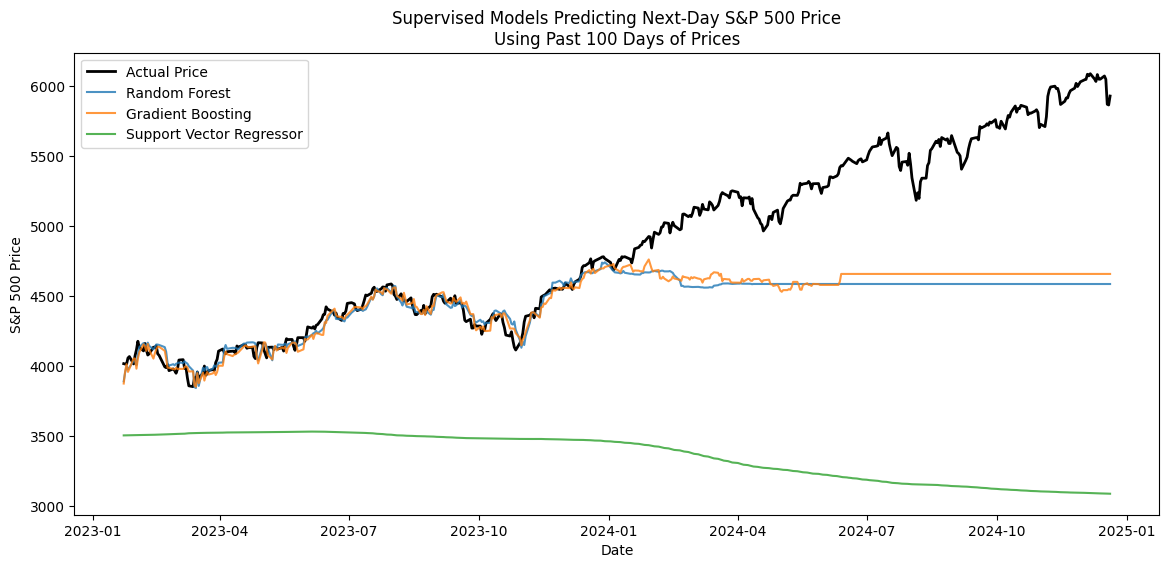

In [101]:
# ---------------------------
# Visualization
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test, label="Actual Price", color="black", linewidth=2)

for name, y_pred in preds.items():
    plt.plot(dates_test, y_pred, label=name, alpha=0.8)

plt.title("Supervised Models Predicting Next-Day S&P 500 Price\nUsing Past 100 Days of Prices")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.show()

## Unsupervised Learning

Several things we could do:
* Using past returns to cluster similar market regimes
* Using past volatility to identify hidden structures in the market
* Using past returns to segment the market into different phases
* Using past returns to detect unusual or anomalous events

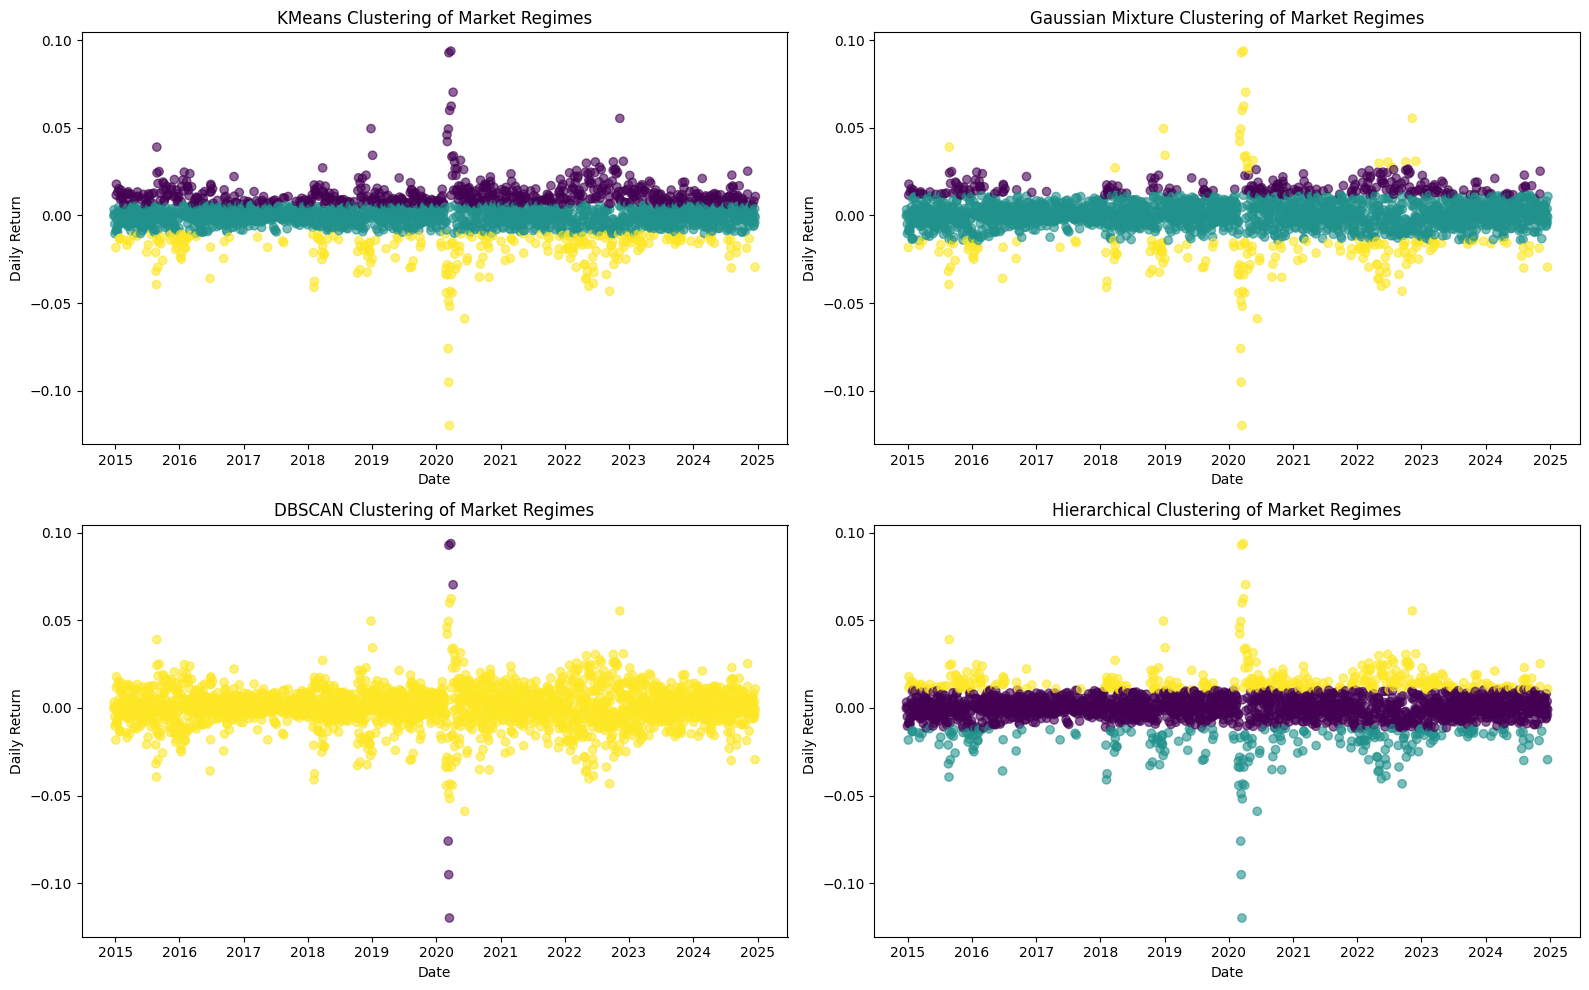

In [102]:
returns = df["S&P500"].pct_change().dropna().values.reshape(-1,1)
dates = df["Date"].iloc[1:]  # align with returns

# ---------------------------
# Apply clustering models
# ---------------------------
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "Gaussian Mixture": GaussianMixture(n_components=3, random_state=42),
    "DBSCAN": DBSCAN(eps=0.01, min_samples=5), 
    "Hierarchical": AgglomerativeClustering(n_clusters=3)
}

clusters = {}
for name, model in models.items():
    if name == "Gaussian Mixture":
        clusters[name] = model.fit_predict(returns)
    else:
        clusters[name] = model.fit_predict(returns)

# ---------------------------
# Visualization
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(16,10))
axes = axes.flatten()

for ax, (name, labels) in zip(axes, clusters.items()):
    ax.scatter(dates, returns, c=labels, cmap="viridis", alpha=0.6)
    ax.set_title(f"{name} Clustering of Market Regimes")
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Return")

plt.tight_layout()
plt.show()

## Insufficient Quantity of Training Data

Baseline (persistence) — MAE: 43.57, RMSE: 3182.17
Final (100% train) — MAE: 390.71, RMSE: 337526.58


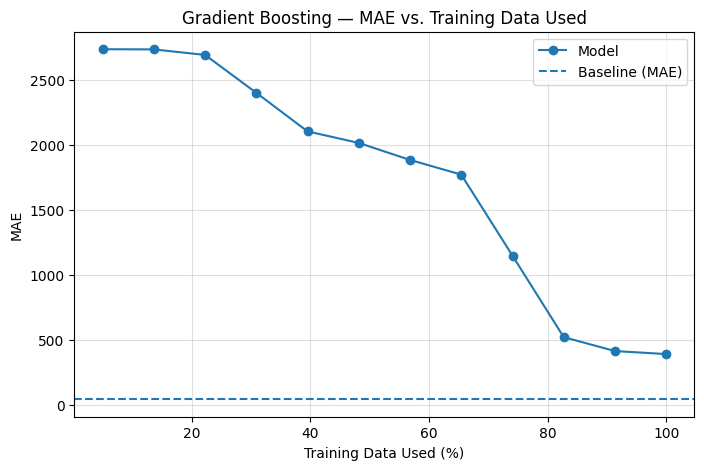

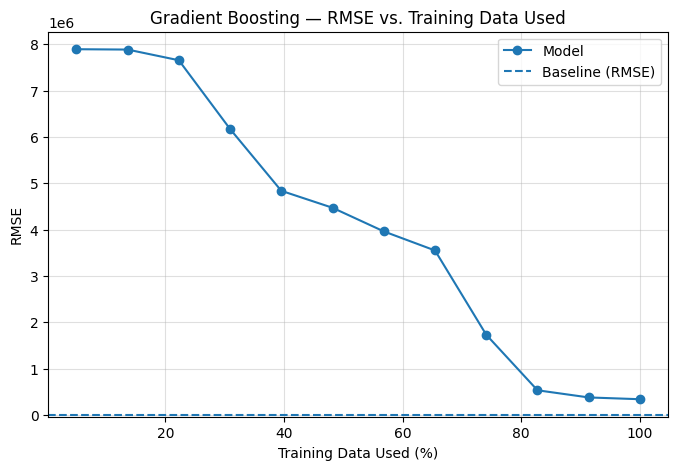

In [105]:
# 1) Build supervised dataset: past prices -> next-day PRICE (regression)
window = 30
prices = df["S&P500"].values.astype(float)

X, y = [], []
for i in range(window, len(prices)-1):
    X.append(prices[i-window:i])     # past 30 days
    y.append(prices[i+1])            # next-day price

X = np.array(X)
y = np.array(y, dtype=float)

# 2) Chronological train/test split (no shuffling)
split = int(len(X) * 0.8)
X_train_full, X_test = X[:split], X[split:]
y_train_full, y_test = y[:split], y[split:]

# --- Naïve baseline on TEST: predict "tomorrow = today's price" (last in window) ---
yhat_baseline = X_test[:, -1]
baseline_mae  = mean_absolute_error(y_test, yhat_baseline)
baseline_rmse = mean_squared_error(y_test, yhat_baseline)

print(f"Baseline (persistence) — MAE: {baseline_mae:.2f}, RMSE: {baseline_rmse:.2f}")

# 3) Train with increasing amounts of data (regression)
train_fracs = np.linspace(0.05, 1.0, 12)  # 5% ... 100%

maes, rmses, r2s = [], [], []

for frac in train_fracs:
    n = max(50, int(len(X_train_full) * frac))  # ensure a reasonable minimum
    X_train, y_train = X_train_full[:n], y_train_full[:n]

    gb = GradientBoostingRegressor(random_state=66)
    gb.fit(X_train, y_train)

    y_pred = gb.predict(X_test)

    maes.append(mean_absolute_error(y_test, y_pred))
    rmses.append(mean_squared_error(y_test, y_pred))

print(f"Final (100% train) — MAE: {maes[-1]:.2f}, RMSE: {rmses[-1]:.2f}")

# 4) Visualizations: one chart per metric vs. training size
x = train_fracs * 100

plt.figure(figsize=(8,5))
plt.plot(x, maes, marker="o", label="Model")
plt.axhline(baseline_mae, linestyle="--", label="Baseline (MAE)")
plt.title("Gradient Boosting — MAE vs. Training Data Used")
plt.xlabel("Training Data Used (%)")
plt.ylabel("MAE")
plt.grid(True, alpha=0.4); plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(x, rmses, marker="o", label="Model")
plt.axhline(baseline_rmse, linestyle="--", label="Baseline (RMSE)")
plt.title("Gradient Boosting — RMSE vs. Training Data Used")
plt.xlabel("Training Data Used (%)")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.4); plt.legend(); plt.show()

## representative training data vs nonrepresentative training data.

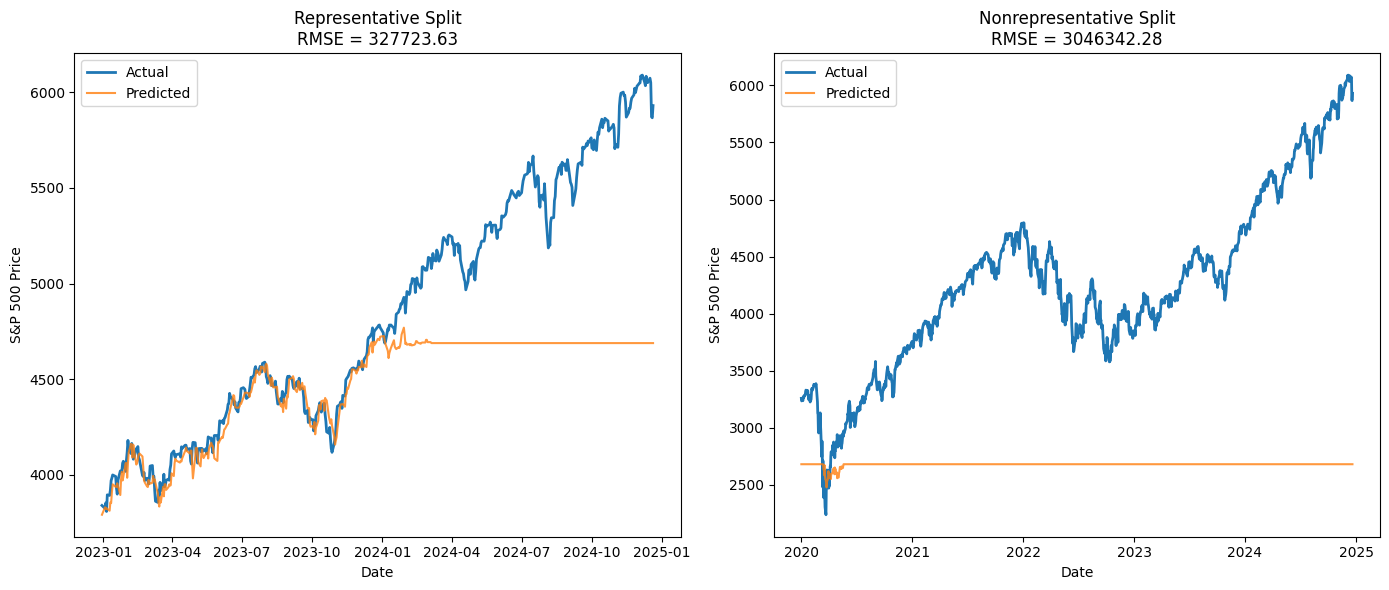

In [104]:
# --- Build supervised dataset: past 30 prices -> next-day price ---
window = 30
prices = df["S&P500"].values
dates = df["Date"].values

X, y, date_idx = [], [], []
for i in range(window, len(prices) - 1):
    X.append(prices[i - window:i])   # past 30 prices
    y.append(prices[i + 1])          # next-day price
    date_idx.append(dates[i + 1])    # label's date (aligns with y)

X = np.array(X)
y = np.array(y)
date_idx = pd.to_datetime(pd.Series(date_idx)).to_numpy(dtype="datetime64[ns]")

# --- Case 1: Representative chronological 80/20 split ---
split = int(len(X) * 0.8)
X_train_rep, X_test_rep = X[:split], X[split:]
y_train_rep, y_test_rep = y[:split], y[split:]
dates_rep = date_idx[split:]  # aligned dates for test set

gb_rep = GradientBoostingRegressor(random_state=42)
gb_rep.fit(X_train_rep, y_train_rep)
y_pred_rep = gb_rep.predict(X_test_rep)
rmse_rep = mean_squared_error(y_test_rep, y_pred_rep)

# --- Case 2: Nonrepresentative split (train early calm, test later volatile) ---
train_cutoff = np.datetime64("2018-01-01")
test_cutoff  = np.datetime64("2020-01-01")

mask_train = (date_idx < train_cutoff)
mask_test  = (date_idx >= test_cutoff)

# Safety check
if mask_train.sum() < 50 or mask_test.sum() < 50:
    print("Warning: few samples in train or test for chosen cutoffs. Adjust dates to match your dataset.")

X_train_nonrep, y_train_nonrep = X[mask_train], y[mask_train]
X_test_nonrep,  y_test_nonrep  = X[mask_test],  y[mask_test]
dates_nonrep = date_idx[mask_test]  # aligned dates for nonrep test set

gb_nonrep = GradientBoostingRegressor(random_state=42)
gb_nonrep.fit(X_train_nonrep, y_train_nonrep)
y_pred_nonrep = gb_nonrep.predict(X_test_nonrep)
rmse_nonrep = mean_squared_error(y_test_nonrep, y_pred_nonrep)

# --- Visualization: Representative vs Nonrepresentative ---
plt.figure(figsize=(14,6))

# Representative
plt.subplot(1,2,1)
plt.plot(dates_rep, y_test_rep, label="Actual", linewidth=2)
plt.plot(dates_rep, y_pred_rep, label="Predicted", alpha=0.8)
plt.title(f"Representative Split\nRMSE = {rmse_rep:.2f}")
plt.xlabel("Date"); plt.ylabel("S&P 500 Price"); plt.legend()

# Nonrepresentative
plt.subplot(1,2,2)
plt.plot(dates_nonrep, y_test_nonrep, label="Actual", linewidth=2)
plt.plot(dates_nonrep, y_pred_nonrep, label="Predicted", alpha=0.8)
plt.title(f"Nonrepresentative Split\nRMSE = {rmse_nonrep:.2f}")
plt.xlabel("Date"); plt.ylabel("S&P 500 Price"); plt.legend()

plt.tight_layout()
plt.show()

## model tuning

Top Hyperparameter Combinations (Sorted by RMSE):
    param_n_estimators  param_learning_rate  param_max_depth  param_subsample  \
20                 300                 0.05                2              0.8   
22                 500                 0.05                2              0.8   
41                 500                 0.10                2              1.0   
50                 300                 0.10                4              0.8   
52                 500                 0.10                4              0.8   
48                 100                 0.10                4              0.8   
39                 300                 0.10                2              1.0   
47                 500                 0.10                3              1.0   
45                 300                 0.10                3              1.0   
29                 500                 0.05                3              1.0   

    mean_test_rmse  
20      384.435287  
22      385.2115

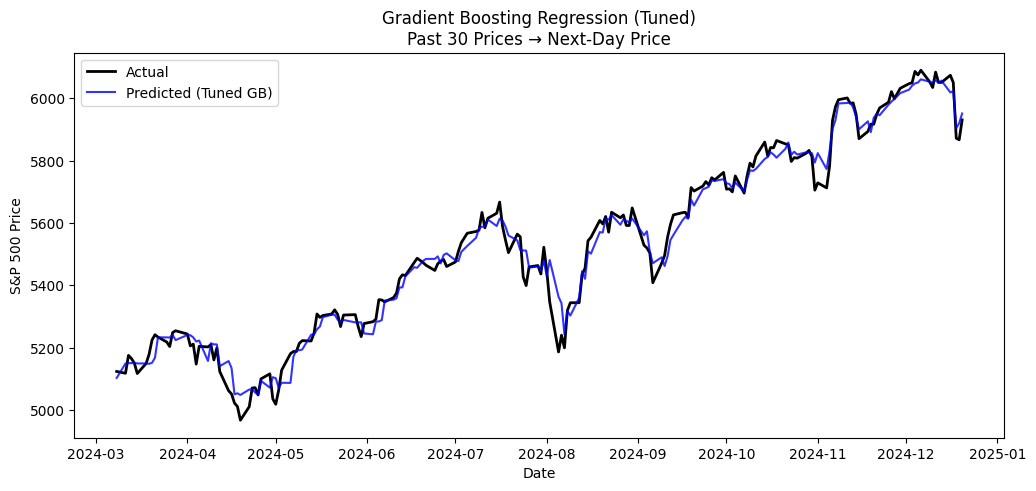

In [113]:
# --- Prepare dataset (past 30 prices -> next-day price) ---
window = 30
prices = df["S&P500"].values

X, y = [], []
for i in range(window, len(prices) - 1):
    X.append(prices[i - window:i])   # past 30 days of prices
    y.append(prices[i + 1])          # next-day price

X = np.array(X)
y = np.array(y)

# --- Time series split (preserves order) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- Parameter grid for tuning ---
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

# --- Grid Search ---
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    gb,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    return_train_score=False
)
grid_search.fit(X, y)

# --- Extract results table ---
results = pd.DataFrame(grid_search.cv_results_)
results["mean_test_rmse"] = -results["mean_test_score"]
rmse_table = results[[
    "param_n_estimators",
    "param_learning_rate",
    "param_max_depth",
    "param_subsample",
    "mean_test_rmse"
]].sort_values(by="mean_test_rmse")

print("Top Hyperparameter Combinations (Sorted by RMSE):")
print(rmse_table.head(10))

# --- Train best model on full dataset ---
best_gb = grid_search.best_estimator_

# Predict last 200 days for visualization
y_pred = best_gb.predict(X[-200:])
dates_test = df["Date"].iloc[window+1:][-200:]
y_test = y[-200:]

# --- Visualization ---
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test, label="Actual", color="black", linewidth=2)
plt.plot(dates_test, y_pred, label="Predicted (Tuned GB)", color="blue", alpha=0.8)
plt.title("Gradient Boosting Regression (Tuned)\nPast 30 Prices → Next-Day Price")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.show()

## Overfitting and Underfitting


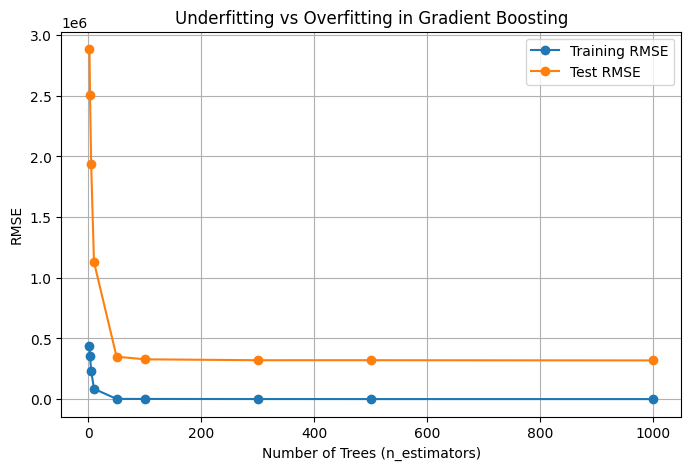

In [111]:
# --- Prepare dataset: past 30 prices -> next-day price ---
window = 30
prices = df["S&P500"].values

X, y = [], []
for i in range(window, len(prices) - 1):
    X.append(prices[i - window:i])
    y.append(prices[i + 1])

X = np.array(X)
y = np.array(y)

# Train/test split (chronological)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Try different model complexities ---
n_estimators_list = [2, 3, 5, 10, 50, 100, 300, 500, 1000]
train_rmse, test_rmse = [], []

for n in n_estimators_list:
    gb = GradientBoostingRegressor(n_estimators=n, random_state=42)
    gb.fit(X_train, y_train)

    y_train_pred = gb.predict(X_train)
    y_test_pred = gb.predict(X_test)

    train_rmse.append(mean_squared_error(y_train, y_train_pred))
    test_rmse.append(mean_squared_error(y_test, y_test_pred))

# --- Visualization ---
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, train_rmse, marker="o", label="Training RMSE")
plt.plot(n_estimators_list, test_rmse, marker="o", label="Test RMSE")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("RMSE")
plt.title("Underfitting vs Overfitting in Gradient Boosting")
plt.legend()
plt.grid(True)
plt.show()

## Reading Material Two (Mandatory):

In the following playlist:  
[YouTube Playlist](https://www.youtube.com/playlist?list=PLblh5JKOoLUIcdlgu78MnlATeyx4cEVeR)  

Each of you needs to:
- Find **one supervised learning** algorithm.  
- Find **one unsupervised learning** algorithm.  

In the next meeting, you will present what you have learned to each other in any format you prefer. <br>


**Tips:**
- Discuss with your teammates, do not choose the same model.
- Presentation should within 5 minutes.

---

## Optional Assignment:

Using **Jupyter Notebook** (Jupyter, Colab, or any editor you prefer):  
- Learn how to use the **`yfinance`** package.  
- Try to download SP500 historical data (Montly, 5 years)